In [1]:
import sys
import os
sys.path.append('../dbm_evaluation')
sys.path.append('../DeepView')

from map_evaluation import P_wrapper, Evaluator, NNinv_keras, NNinv_torch, MapBuilder


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
#import knn and decision tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# import make blobs
from sklearn.datasets import make_blobs


from scipy.spatial import Delaunay
from scipy.interpolate import Rbf

# date
from datetime import datetime

from umap import UMAP

from tqdm import tqdm

from ssnp import SSNP

In [2]:
# # import PCA
# from sklearn.decomposition import PCA

# blob = make_blobs(n_samples=1000, n_features=1000, centers=3, cluster_std=1.0, center_box=(-10.0, 10.0), shuffle=True, random_state=1)
# pca = PCA(n_components=2)
# pca.fit(blob[0])
# pca_blob = pca.transform(blob[0])

# plt.scatter(pca_blob[:,0], pca_blob[:,1], c=blob[1], cmap='viridis')

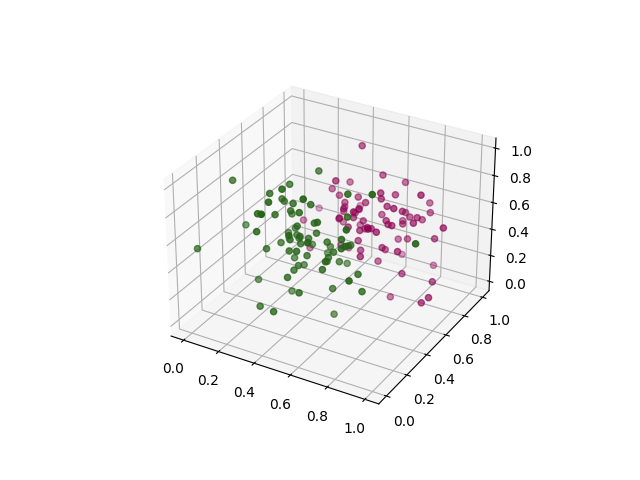

In [3]:
%matplotlib widget
blob0 = make_blobs(n_samples=150, n_features=3, centers=2, cluster_std=3, random_state=1)
# blob0 = make_blobs(n_samples=150, n_features=3, centers=5, cluster_std=1.2, random_state=6666)
y = blob0[1]
# plot the blobs in 3D"
fig_3d = plt.figure()
ax_3d = fig_3d.add_subplot(111, projection='3d')
# ax.view_init() what is the default view? type help(ax.view_init)
# help(ax.view_init)
CMAP = 'PiYG'
pinot_clor_map = cm.get_cmap(CMAP)
ponit_clor = pinot_clor_map(y/y.max())

#####
lazy_scaler = MinMaxScaler()
blob0 = list(blob0)
blob0[0] = lazy_scaler.fit_transform(blob0[0])
#####

ax_3d.scatter(blob0[0][:,0], blob0[0][:,1], blob0[0][:,2], c=ponit_clor, )#cmap='tab10', )

In [4]:
class Simple_P_wrapper:
    def __init__(self, P, Pinv):
        self.P = P
        self.Pinv = Pinv
    def __call__(self, x):
        return self.P(x)
    def transform(self, x):
        return self.P.transform(x)
    def inverse_transform(self, x):
        return self.Pinv.transform(x)

    def fit(self, x, y=None, clf=None):
        self.P.fit(x)
        self.Pinv.fit(self.P.transform(x), x )
        return self

p = UMAP(n_components=2, random_state=43, n_neighbors=30, min_dist=0.9)
Pinv = NNinv_torch(dims=[2048]*4)
proj = Simple_P_wrapper(p, Pinv)

device:  cuda:0


In [5]:
scaler = MinMaxScaler()
X = scaler.fit_transform(blob0[0])
# X = blob0[0]
y = blob0[1]

NNinv_keras = 0
NNinv_torch = 1
deepview = 0
ssnp = 0

name_list = ['NNinv_keras', 'NNinv_torch', 'deepview', 'ssnp']
#get the none zero name
name_plot = [name_list[i] for i in [NNinv_keras, NNinv_torch, deepview, ssnp] if i != 0][0]

# ssnp = SSNP(patience=5, opt='adam', bottleneck_activation='linear', verbose=0)
proj = P_wrapper(NNinv_Keras=NNinv_keras, NNinv_Torch=NNinv_torch, deepview=deepview, ssnp=ssnp)
clf = linear_model.LogisticRegression()
clf = SVC(probability=True)
# clf = RandomForestClassifier()
dbm = P_wrapper(NNinv_Torch=1, deepview=0, ssnp=0, NNinv_Keras=0)
ssnp = P_wrapper(NNinv_Keras=0, NNinv_Torch=0, deepview=0, ssnp=1)
DV = P_wrapper(NNinv_Keras=0, NNinv_Torch=0, deepview=1, ssnp=0)


clf.fit(X, y)

DV.fit(X, y, clf, lam=0.65)
dbm.fit(X, y, clf)
ssnp.fit(X, y, clf)


100%|██████████| 150/150 [00:00<00:00, 779.24it/s]


updating matrices
(0,) (150, 150)
discr 0.00017118453979492188
(0,) (150, 150)
fitting mapper
transforming
fitting inverse


/home/peyote/miniconda3/envs/tf3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


done
fitting time:  4.2629714012146
device:  cuda:0
Early stopping at epoch 42
fitting time:  1.8559575080871582
device:  /device:GPU:0


2023-09-11 15:50:57.279316: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 15:50:57.280597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-11 15:50:57.284120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-11 15:50:57.284258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

fitting time:  2.2969532012939453


2.2969532012939453

In [6]:
# import tensorflow as tf
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# if len(physical_devices) > 0:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)


# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
! pip list | grep tensor

tensorboard                   2.8.0
tensorboard-data-server       0.6.1
tensorboard-plugin-wit        1.8.1
tensorflow                    2.8.0
tensorflow-estimator          2.11.0
tensorflow-io-gcs-filesystem  0.28.0


calculating probability map
calculating gradient map
0.25941283


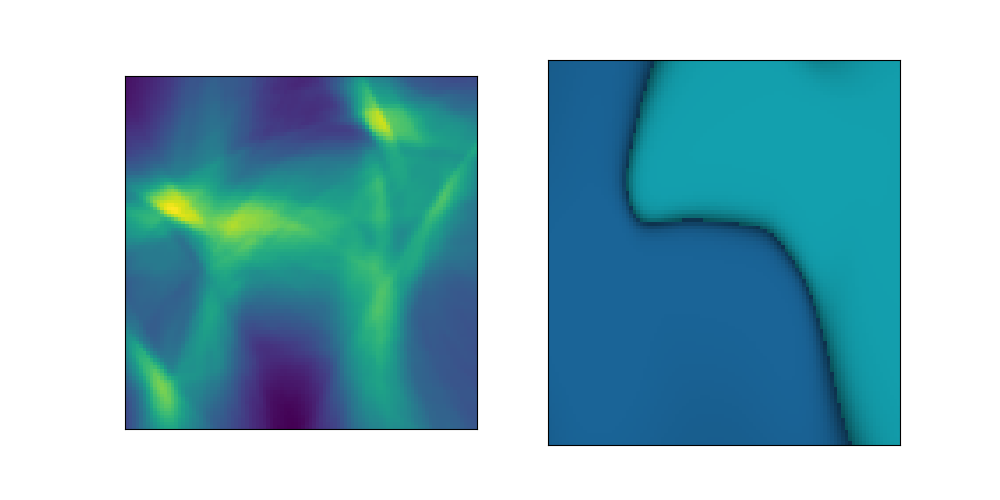

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
map_builder = MapBuilder(clf, dbm, X, y, grid=100)
ax_grad = map_builder.plot_gradient_map(ax=ax1)
dv_map = map_builder.plot_prob_map(ax=ax2)
plt.show()

[]

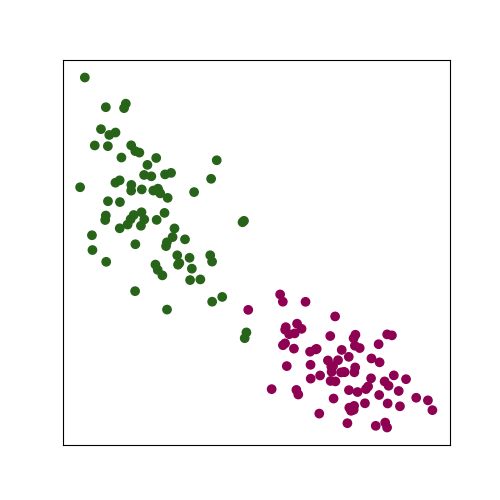

In [8]:
X_2d = ssnp.transform(blob0[0])
# scale the data to be between 0 and 1
# scaler2d = MinMaxScaler()
# X_2d = scaler2d.fit_transform(X_2d)


fig, ax = plt.subplots(figsize=(5,5) )
ax.scatter(X_2d[:,0], X_2d[:,1], c=ponit_clor)
# no ticks
ax.set_xticks([])
ax.set_yticks([])
# suqare aspect ratio`
# ax.set_aspect('equal')
# make directory if it doesn't exist
# if not os.path.exists('./figures/inlustrate_dbm'):
#     os.makedirs('./figures/inlustrate_dbm')
# fig.savefig('./figures/inlustrate_dbm/2d_1')

In [9]:
# %matplotlib widget
GRID = 20
# CMAP = 'tab10'


In [10]:
def plot_inverse_map(P_inv, GRID=GRID, clf=clf, ax=None, CMAP=CMAP, single_color=False):

    

    
    X_2d = P_inv.transform(blob0[0])


    xx, yy = np.meshgrid(np.linspace(X_2d[:,0].min(), X_2d[:,0].max(), GRID), np.linspace(X_2d[:,1].min(), X_2d[:,1].max(), GRID))
    XY = np.c_[xx.ravel(), yy.ravel()]
    XY_3d = P_inv.inverse_transform(XY)
    XY_3d = scaler.inverse_transform(XY_3d)
    labels = clf.predict(XY_3d)
    ## grids with labels
    tab10 = cm.get_cmap(CMAP)
    labels_color = tab10(labels/labels.max())
    labels_color_2d = tab10(labels.reshape(GRID,GRID)/labels.max())
    # set alpha to 0.5
    labels_color_2d[:, : ,3] = 0.7
    # print(labels_color_2d.shape)
    # print(XY_3d[:,0].reshape(GRID,GRID).shape)
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    # visual_scaler = MinMaxScaler(0, GRID)

    # # ax_grid_dbm.scatter(XY_3d[:,0], XY_3d[:,1], XY_3d[:,2], c=labels_color[:], alpha=0.9, marker='+', cmap = 'tab10', s=100)
    # ax.scatter(blob0[0][:,0], blob0[0][:,1], blob0[0][:,2], c=blob0[1], cmap='tab10', ec='k', s=7, linewidth=0.1, alpha=0.75)

    # # ax_grid_dbm.plot_wireframe(XY_3d[:,0].reshape(GRID,GRID), XY_3d[:,1].reshape(GRID,GRID), XY_3d[:,2].reshape(GRID,GRID), colors=labels_color, alpha=0.5,)
    # ax.plot_surface(
    #     XY_3d[:,0].reshape(GRID,GRID), XY_3d[:,1].reshape(GRID,GRID), XY_3d[:,2].reshape(GRID,GRID), facecolors=labels_color_2d, #shade=False, #alpha=0.5, 
    #       linewidth=0.0, antialiased=False, rstride=1, cstride=1, )
    
    ########################### volume version plot##########
        # ax_grid_dbm.scatter(XY_3d[:,0], XY_3d[:,1], XY_3d[:,2], c=labels_color[:], alpha=0.9, marker='+', cmap = 'tab10', s=100)
    scatter2plot = blob0[0] * GRID
    ax.scatter(scatter2plot[:,0], scatter2plot[:,1], scatter2plot[:,2], c=blob0[1], cmap=CMAP, ec='k', s=7, linewidth=0.1, alpha=0.75)

    XY_3d *= GRID

    if not single_color:
        ax.plot_surface(
            XY_3d[:,0].reshape(GRID,GRID), XY_3d[:,1].reshape(GRID,GRID), XY_3d[:,2].reshape(GRID,GRID), facecolors=labels_color_2d, #shade=False, #alpha=0.5, 
            linewidth=0.0, antialiased=False, rstride=1, cstride=1, )
    else:
        # single color
        single_clor = (0.8, 0.8, 0.8, 0.8)
        single_cloer_2d = np.ones((GRID, GRID, 4))
        single_cloer_2d[:, :, 0] = single_clor[0]
        single_cloer_2d[:, :, 1] = single_clor[1]
        single_cloer_2d[:, :, 2] = single_clor[2]
        single_cloer_2d[:, :, 3] = single_clor[3]

        ax.plot_surface(
            XY_3d[:,0].reshape(GRID,GRID), XY_3d[:,1].reshape(GRID,GRID), XY_3d[:,2].reshape(GRID,GRID), facecolors=single_cloer_2d, ec=None, #shade=False, #alpha=0.5, 
              linewidth=0.0, antialiased=False, rstride=1, cstride=1, )
    
    ######################

    # ratio = 0.1
    # ax.set_xlim(blob0[0][:,0].min()+ratio, blob0[0][:,0].max()*.9)
    # ax.set_ylim(blob0[0][:,1].min()+ratio, blob0[0][:,1].max()*.9)
    # ax.set_zlim(blob0[0][:,2].min()+ratio, blob0[0][:,2].max()*.9)


    return ax, XY_3d

def adjust_ax(ax):
    # # Make panes transparent
    # ax.xaxis.pane.fill = False # Left pane
    # ax.yaxis.pane.fill = False # Right pane
    # ax.zaxis.pane.fill = False # Right pane

    ### Remove grid lines
    # ax.grid(False)

    ## Remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # ## Transparent spines
    # ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    # ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    # ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

    # ## Transparent panes
    # ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    ## No ticks
    # ax.set_xticks([]) 
    # ax.set_yticks([]) 
    # ax.set_zticks([])

    # backgroud color
    ax.set_facecolor((0.95, 0.95, 0.95, 0.0))
    return ax

# plot_inverse_map(dbm)
# plt.show()

In [11]:
from skimage.measure import marching_cubes

def plot_volume2(clf, ax=None, grid=GRID, CMAP=CMAP, scatter=False, voxel=True, d_surface=False):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    xx, yy, zz = np.meshgrid(np.linspace(blob0[0][:,0].min(), blob0[0][:,0].max(), grid),
                                np.linspace(blob0[0][:,1].min(), blob0[0][:,1].max(), grid),
                                np.linspace(blob0[0][:,2].min(), blob0[0][:,2].max(), grid))
    
    XYZ = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
    labels = clf.predict(XYZ)
    label_cube = labels.reshape(grid, grid, grid)

    # swap axis 
    label_cube = np.swapaxes(label_cube, 0, 1)
    

    cmap = cm.get_cmap(CMAP)
    labels_color_3d = cmap(label_cube/label_cube.max())
    # labels_color_3d = labels_color.reshape(grid, grid, grid, 4)
    labels_color_3d[:, :, :, 3] = 0.4
    voxels = np.ones((grid, grid, grid), dtype=bool)
    if voxel:
        ax.voxels(voxels, facecolors=labels_color_3d, linewidth=0.1, alpha=0.4, shade=False) #edgecolor='k', 

    # Use marching cubes to obtain the surface mesh
    verts, faces, normals, values = marching_cubes(label_cube, level=0.5)

    if d_surface:
        # Plotting the surface
        ax.plot_trisurf(verts[:, 0], verts[:, 1], verts[:, 2], triangles=faces, alpha=0.5, antialiased=True, color='#8888BB', edgecolor=None)

    if scatter:
        scatter2plot = blob0[0] * GRID
        ax.scatter(scatter2plot[:,0], scatter2plot[:,1], scatter2plot[:,2], c=blob0[1], cmap=CMAP, ec='k', s=7, linewidth=0.1, alpha=0.95)

    return ax, verts


def find_intersection(verts, XY_3d, tolerance=0.1):
    intersection_points = []
    for vertex in verts:
        distances = np.linalg.norm(XY_3d - vertex, axis=1)
        if np.any(distances < tolerance):
            intersection_points.append(vertex)
    return np.array(intersection_points)

(28, 3)


Text(0.5, 0, 'Z')

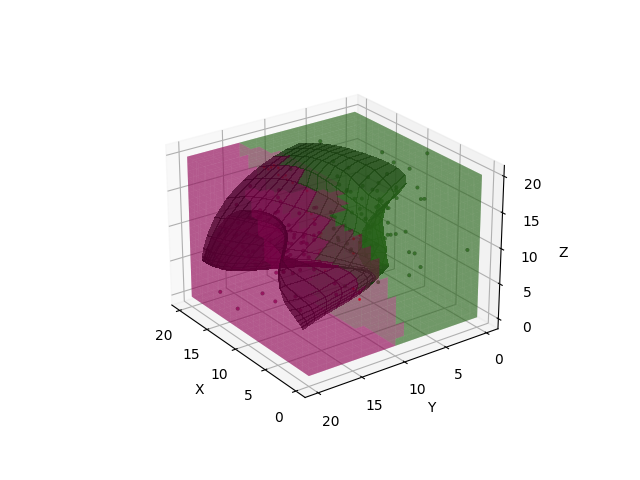

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax, verts  = plot_volume2(clf, ax=ax, grid=GRID, CMAP=CMAP, d_surface=False)
ax, DM_3d = plot_inverse_map(dbm, GRID=GRID, clf=clf, ax=ax, CMAP=CMAP, single_color=False)

# # Find intersection points
intersection_points = find_intersection(verts, DM_3d, tolerance=0.8)
print(intersection_points.shape)
# # Plot the intersection points
ax.scatter(intersection_points[:, 0], intersection_points[:, 1], intersection_points[:, 2], c='r', s=5, label='Intersection', marker='.')

# # set camera position
ax.view_init(25, 144)
# # ax.view_init(30, 30)

# set axis label
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


100%|██████████| 150/150 [00:00<00:00, 395.93it/s]


Text(0.5, 0.92, 'DeepView')

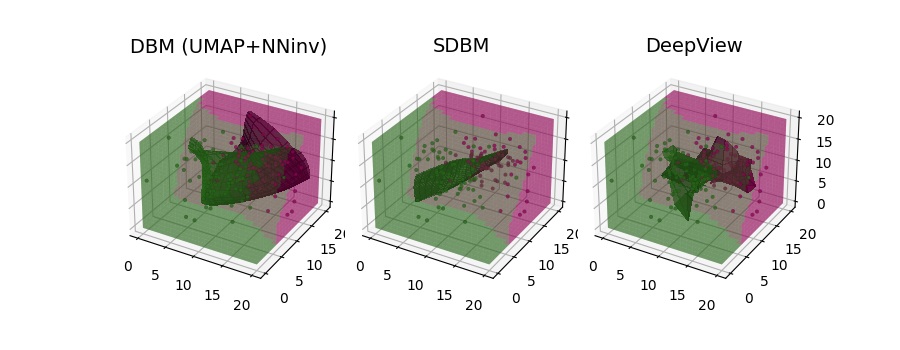

In [13]:
# build a fig with 3 3d-axes
fig = plt.figure(figsize=(9,3.5))
ax1 = fig.add_subplot(131, projection='3d', )
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')
# white space between subplots
fig.subplots_adjust(wspace=0.0, hspace=0.0)

plot_inverse_map(dbm, ax=ax1)
plot_inverse_map(ssnp, ax=ax2)
plot_inverse_map(DV, ax=ax3)

# plot the volume
plot_volume2(clf, ax=ax1)
plot_volume2(clf, ax=ax2)
plot_volume2(clf, ax=ax3)



## set view angle
# viual_angle = (44, -44, 20)
# ax1.view_init(*viual_angle)
# ax2.view_init(*viual_angle)
# ax3.view_init(*viual_angle)

ax1.set_title('DBM (UMAP+NNinv)', fontsize=14)
ax2.set_title('SDBM', fontsize=14)
ax3.set_title('DeepView', fontsize=14)

# fig.savefig('./figures/3d_all.pdf', dpi=300, bbox_inches='tight')
# fig.savefig('../DecisionMap_Comapre_manuscript/figures/demo3d_new.pdf', dpi=300, bbox_inches='tight')

In [14]:
classifiers = {
    'placeholder_clf': linear_model.LogisticRegression(),
    'Logistic Regression': linear_model.LogisticRegression(),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'MLP': MLPClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'K-NN': KNeighborsClassifier(),
}

## fit the models
for name, clf in classifiers.items():
    clf.fit(X, y)
    
dms = {
    'placeholder': P_wrapper(),
    'DBM': dbm,
    'SDBM': ssnp,
    'DeepView': DV,
}



/home/peyote/miniconda3/envs/tf3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


100%|██████████| 150/150 [00:00<00:00, 458.57it/s]


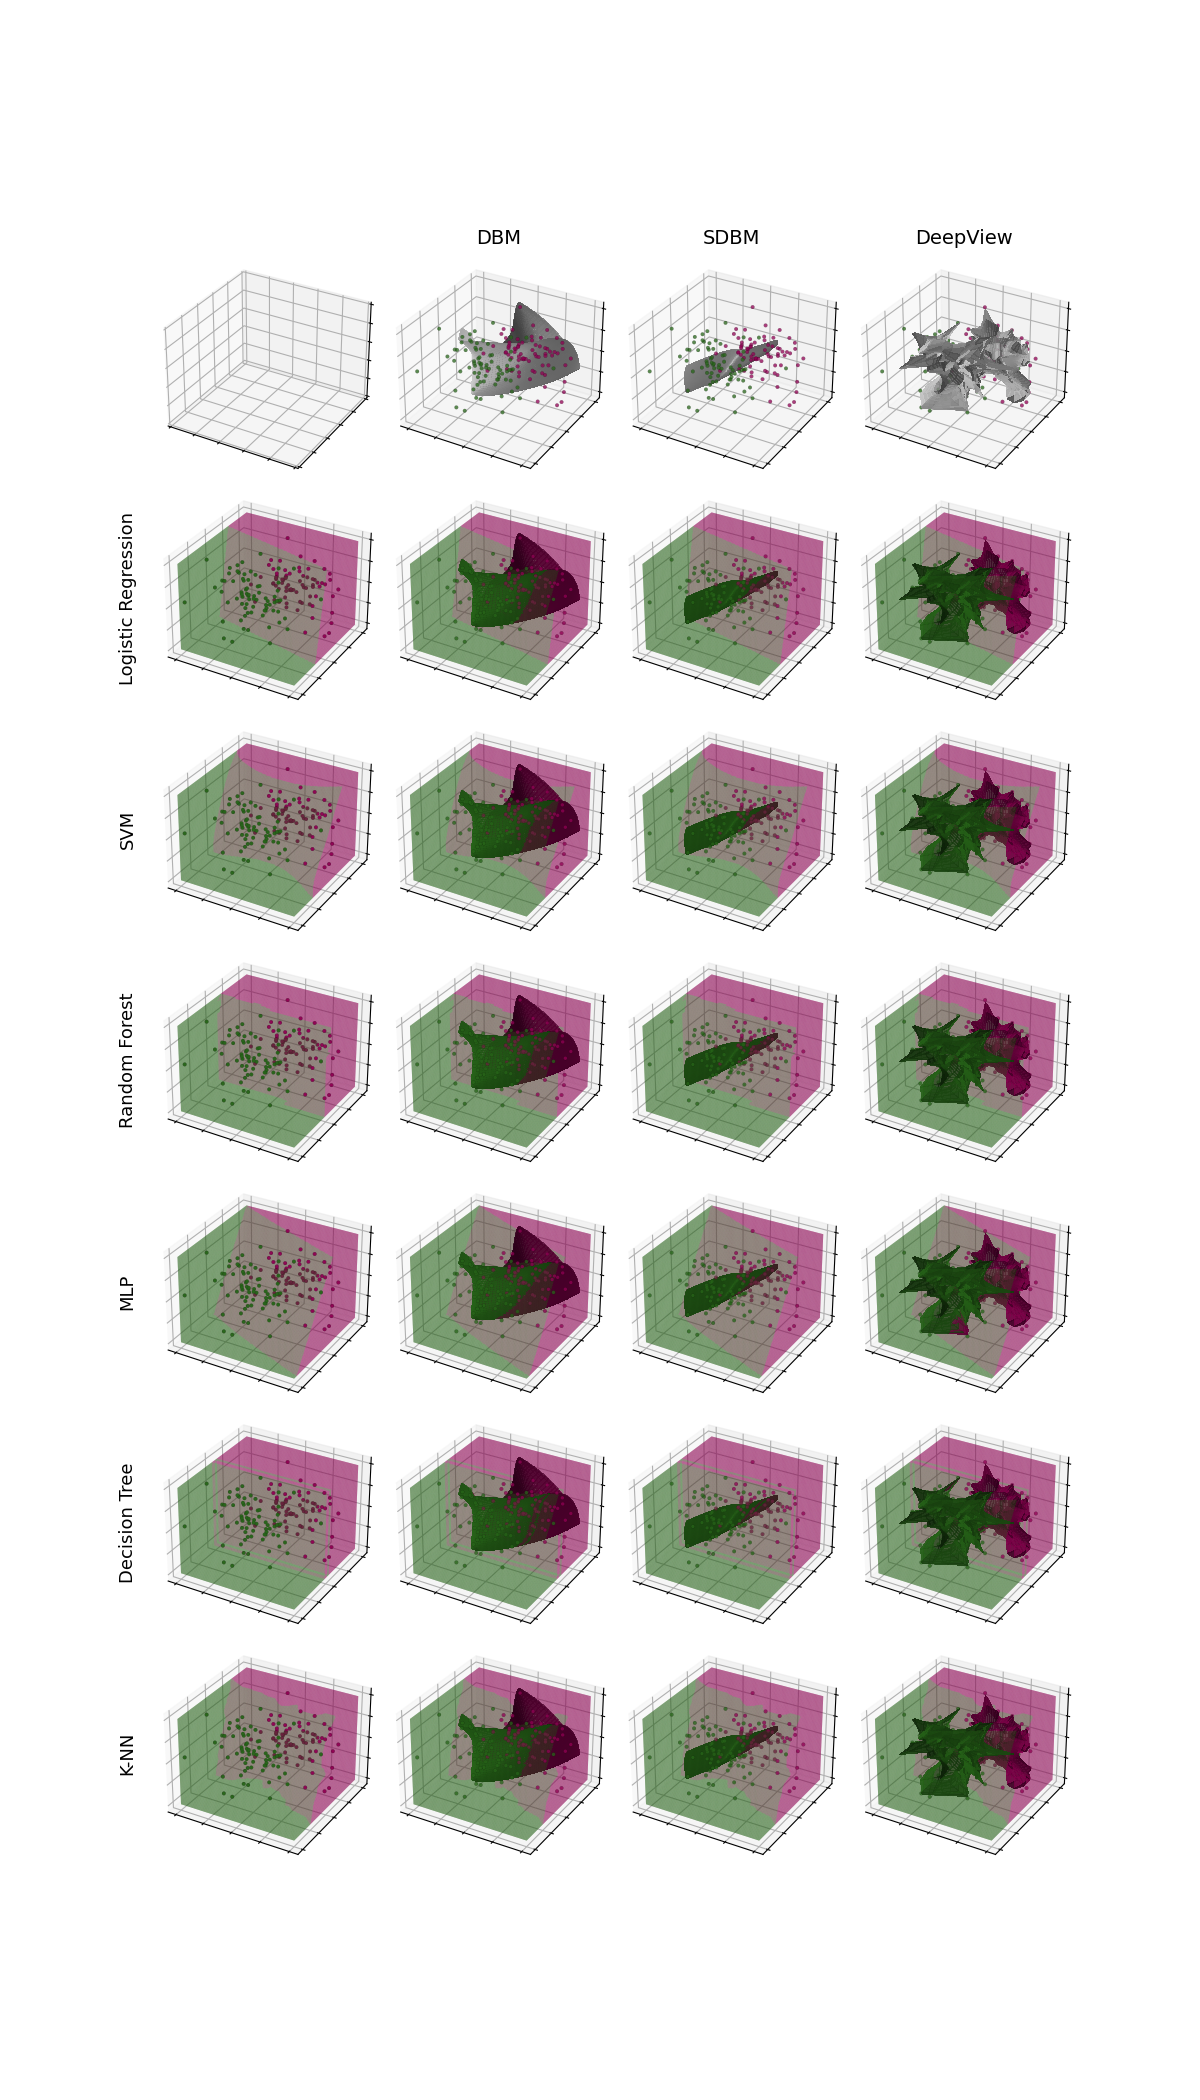

In [15]:
## plot the figur, cols is number of dms+1, rows is number of classifiers+1
GRID = 100
cols = len(dms) 
rows = len(classifiers) 

fig3d = plt.figure(figsize=(cols*3, rows*3))
fig3d.subplots_adjust(wspace=0.0, hspace=0.0)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    for j, (dm_name, dm) in enumerate(dms.items()):
        # print(i, j)
        ax = fig.add_subplot(rows, cols, i*cols+j+1, projection='3d')
        adjust_ax(ax)
        if i == 0 and j == 0:
            continue
        if i == 0:
            # 3d plot
            
            plot_inverse_map(dm, ax=ax, clf=clf, single_color=True, GRID=GRID)
            ax.set_title(dm_name, fontsize=14)

        elif j == 0:
            plot_volume2(clf, ax=ax, grid=GRID, CMAP=CMAP, scatter=True, voxel=True, d_surface=False)
            # a label at the left of each row
            ax.text2D(-0.1, 0.5, clf_name, fontsize=13, transform=ax.transAxes, rotation=90, va='center', ha='center')
        else:
            plot_inverse_map(dm, ax=ax, clf=clf, single_color=False, GRID=GRID)
            plot_volume2(clf, ax=ax, grid=GRID, CMAP=CMAP, scatter=False, voxel=True, d_surface=False)

        adjust_ax(ax)
        # ax.view_init(25, 144)
        # ax.view_init(35, 35)
# fig.savefig('./figures/3d_all.pdf', dpi=300, bbox_inches='tight')



In [16]:
fig3d.savefig('../paper/PAPER_intrinsic_dim/figures/dm3d_all.png', dpi=300, bbox_inches='tight')

100%|██████████| 150/150 [00:00<00:00, 453.40it/s]


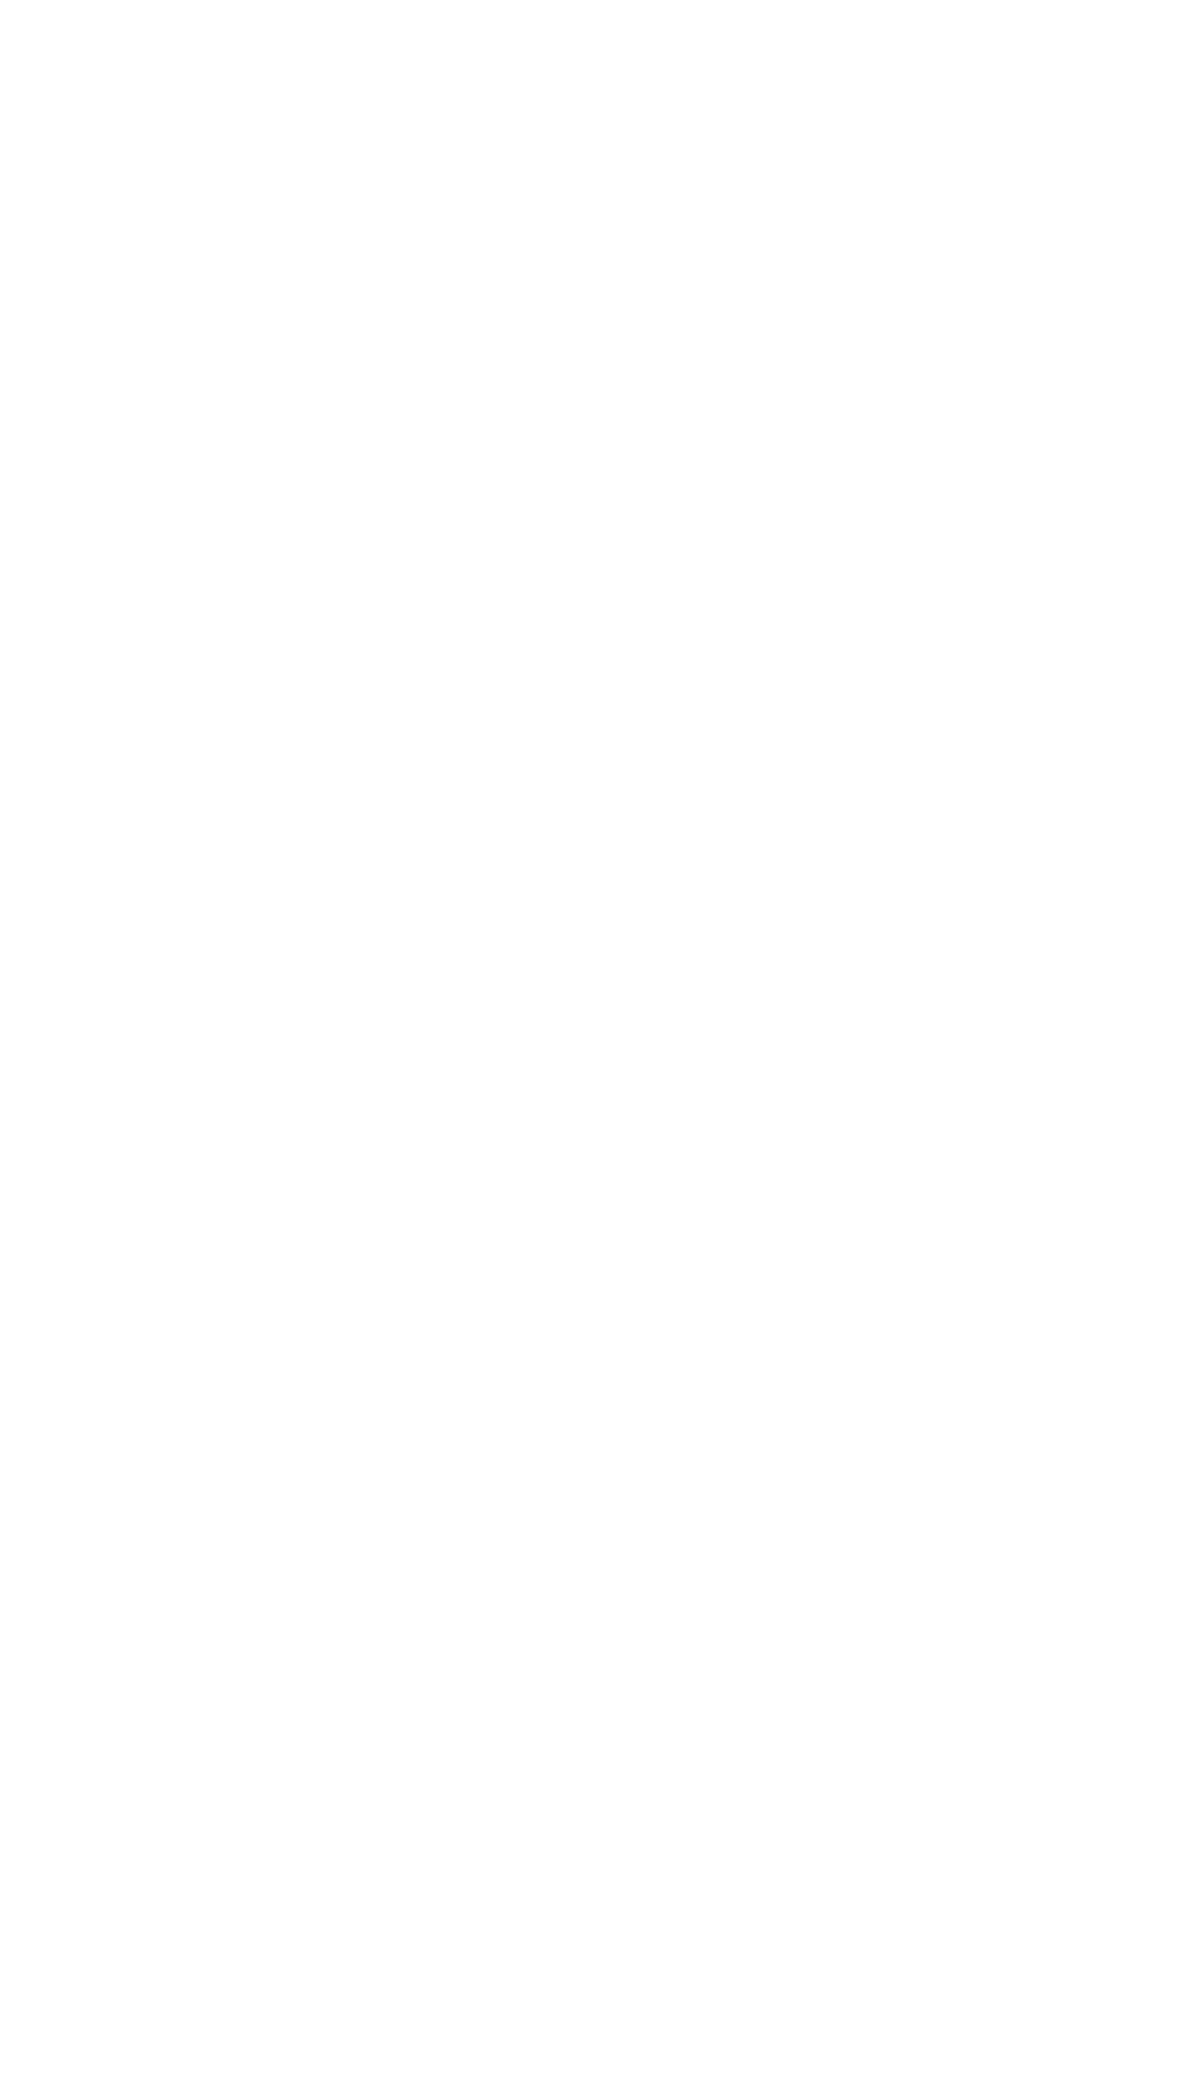

In [19]:
# swap axis 0 and 1 in figure 3d

fig3d = plt.figure(figsize=(cols*3, rows*3))
fig3d.subplots_adjust(wspace=0.0, hspace=0.0)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    for j, (dm_name, dm) in enumerate(dms.items()):
        # print(i, j)
        ax = fig.add_subplot(rows, cols, i*cols+j+1, projection='3d')
        adjust_ax(ax)
        if i == 0 and j == 0:
            continue
        if i == 0:
            # 3d plot
            
            plot_inverse_map(dm, ax=ax, clf=clf, single_color=True, GRID=GRID)
            ax.set_title(dm_name, fontsize=14)

        elif j == 0:
            plot_volume2(clf, ax=ax, grid=GRID, CMAP=CMAP, scatter=True, voxel=True, d_surface=False)
            # a label at the left of each row
            ax.text2D(-0.1, 0.5, clf_name, fontsize=13, transform=ax.transAxes, rotation=90, va='center', ha='center')
        else:
            plot_inverse_map(dm, ax=ax, clf=clf, single_color=False, GRID=GRID)
            plot_volume2(clf, ax=ax, grid=GRID, CMAP=CMAP, scatter=False, voxel=True, d_surface=False)

        adjust_ax(ax)
        # ax.view_init(25, 144)
        # ax.view_init(35, 35)
fig.savefig('./figures/dm3d_all_horizontal.png', dpi=300, bbox_inches='tight')

calculating probability map
calculating probability map
calculating probability map
calculating probability map
calculating probability map
calculating probability map
calculating probability map
calculating probability map
calculating probability map
calculating probability map
calculating probability map
calculating probability map
calculating probability map
calculating probability map
calculating probability map
calculating probability map
calculating probability map
calculating probability map


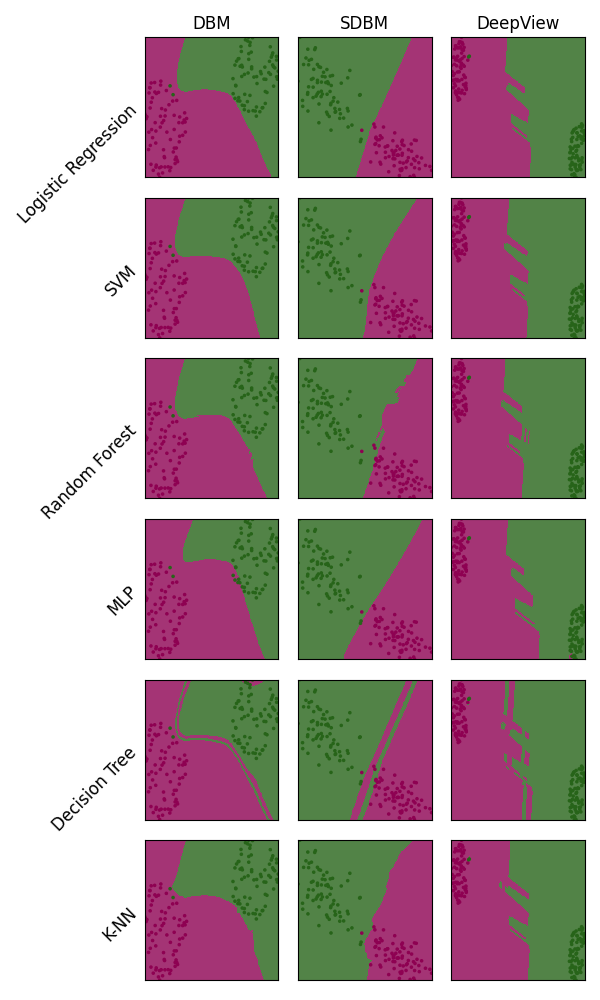

In [17]:
## 

fig, axes = plt.subplots(rows-1, cols-1, figsize=(6, 10))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    for j, (dm_name, dm) in enumerate(dms.items()):
        if i == 0 or j == 0:
            continue
        ax = axes[i-1, j-1]
        # sqaure aspect ratio
        ax.set_aspect('equal')
        # legend false
        

        dm_holder = MapBuilder(clf, dm, X, y, grid=300)
        ax = dm_holder.plot_prob_map(ax=ax, proba=False, cmap=cm.PiYG, epsilo=0.8)
        dm_holder.plot_training_data(ax=ax, cmap=cm.PiYG)
        ax.legend_ = None
        if i == 1:
            ax.set_title(dm_name, fontsize=12)
        if j == 1:
            ax.set_ylabel(clf_name, fontsize=12, rotation=45, ha='right', va='center')
plt.tight_layout()

In [18]:
fig.savefig('../paper/PAPER_intrinsic_dim/figures/dm2d_all.png', dpi=300, bbox_inches='tight')